# TODO:
- Обновить на гитхабе этот ноутбук когда доучится

# Обучение MeshVAE!
## Импорт библиотек

In [1]:
import torch
import torch.nn as nn

import os

import pandas as pd
import matplotlib.pyplot as plt

import torchvision.transforms as transforms


from torch.utils.checkpoint import checkpoint_sequential
from torchvision.transforms import Resize
from pathlib import Path
from tqdm import tqdm

from pytorch3d.renderer import look_at_view_transform
from pytorch3d.renderer import (
FoVPerspectiveCameras, VolumeRenderer,
NDCGridRaysampler, EmissionAbsorptionRaymarcher
)

from modelnet import ModelNetRendersNoLabels

from model_collection.MeshVAE import MeshVAE
from model_collection.utils import huber_loss, max_VRAM_optim_fit
from model_collection.VAE_loss.VaeLoss import VAELossGAN
from model_collection.VAE_loss.vgg19 import VGG19

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

## Определение девайса, датасета и даталоадера

In [2]:
USE_CUDA = True
device = 'cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu'
print('Using', device)

data_sheet = pd.read_csv('./modelnet_renders_metadata.csv')
data_train = data_sheet[data_sheet['split'] == ' train']
data_test = data_sheet[data_sheet['split'] == ' test']

image_size = 64
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.Normalize(0.5, 0.5)])

dataset_train = ModelNetRendersNoLabels(dataset_root_dir=Path('/home/student/work/3d_Generative/model/modelNet_renders'),data_sheet=data_train, transform=transform, device=device)
dataset_test = ModelNetRendersNoLabels(dataset_root_dir=Path('/home/student/work/3d_Generative/model/modelNet_renders'),data_sheet=data_test, transform=transform, device=device)

print(f"Test set has {len(data_test['class'].unique())} classes\nTrain set has {len(data_train['class'].unique())} classes")

data_overfit = pd.DataFrame([data_train.iloc[0], data_train.iloc[0]]) # , data_test.iloc[450]
dataset_overfit = ModelNetRendersNoLabels(dataset_root_dir=Path('/home/student/work/3d_Generative/model/modelNet_renders'),data_sheet=data_overfit, transform=None, device=device)
overfit_dl = torch.utils.data.DataLoader(dataset = dataset_overfit,
                                                      batch_size = 2,
                                                      num_workers = 0,
                                                      shuffle = True)

BATCH_SIZE = 10

train_dl = torch.utils.data.DataLoader(dataset = dataset_train,
                                                      batch_size = BATCH_SIZE,
                                                      num_workers = 0,
                                                      shuffle = True)

test_dl = torch.utils.data.DataLoader(dataset = dataset_test,
                                                      batch_size = BATCH_SIZE,
                                                      num_workers = 0,
                                                      shuffle = False)

Using cuda
Test set has 10 classes
Train set has 10 classes


## Определение модели, оптимизатора и метода learning rate annealing

In [3]:
descriptor_sil = VGG19(num_classes=1).to(device)
descriptor_col = VGG19(num_classes=1).to(device)

descriptor_sil.load_state_dict(torch.load(Path('./models') / 'descriptor_sil' / 'best.pt'))
descriptor_col.load_state_dict(torch.load(Path('./models') / 'descriptor_col' / 'best.pt'))


sil_optimizer = torch.optim.Adam(descriptor_sil.parameters(), lr=1e-5)
col_optimizer = torch.optim.Adam(descriptor_col.parameters(), lr=1e-5)


model = MeshVAE().to(device)
model.load_state_dict(torch.load(Path('./models') / 'MeshVAE' / '16' / 'last.pt'))
criterion = VAELossGAN(device=device, clamp=True, clamp_threshold=10000., 
                       adv_net_sil=descriptor_sil, adv_net_sil_optim=sil_optimizer, 
                       adv_net_col=descriptor_col, adv_net_col_optim=col_optimizer,
                       KLD_coef = 1.,)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = None # torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=60, T_mult=2)

## Обучение!

In [ ]:
epochs = 10
torch.cuda.empty_cache()
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
torch.autograd.set_detect_anomaly(True)
max_VRAM_optim_fit(train_launch=16,
                   model=model, optimizer=optimizer, criterion=criterion,
                   train_dl=train_dl, test_dl=test_dl, 
                   device=device, epochs=epochs,
                   scheduler=scheduler,
                   weights_save_dir=Path('./models'),
                   early_stopping=False, early_stopping_tolerance = 5,
                   restore_best_weights=False, save_loss_history=True, overfit_mode=False, mode='gan')

==========Epoch 1==========
Training...


/home/student/miniforge3/envs/pytorch3d/lib/python3.9/site-packages/torch/utils/checkpoint.py:553: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/student/miniforge3/envs/pytorch3d/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/student/miniforge3/envs/pytorch3d/lib/python3.9/site-packages/pytorch3d/renderer/implicit/raymarching.py:188: UserWarning: One or more elements of rays_densities are outside of validrange (0.0, 1.0)
  warnings.warn(
100%|██████████| 399/399 [30:22<00:00,  4.57s/it]


Train loss: 0.90 | Test loss: 0.90
Saved weights to models/MeshVAE/16/best.pt
==========Epoch 2==========
Training...


100%|██████████| 399/399 [30:19<00:00,  4.56s/it]


Train loss: 0.89 | Test loss: 0.89
Saved weights to models/MeshVAE/16/best.pt
==========Epoch 3==========
Training...


100%|██████████| 399/399 [30:18<00:00,  4.56s/it]


Train loss: 0.89 | Test loss: 0.89
Saved weights to models/MeshVAE/16/last.pt
==========Epoch 4==========
Training...


100%|██████████| 399/399 [30:23<00:00,  4.57s/it]


Train loss: 0.88 | Test loss: 0.88
Saved weights to models/MeshVAE/16/best.pt
==========Epoch 5==========
Training...


100%|██████████| 399/399 [30:20<00:00,  4.56s/it]


Train loss: 0.89 | Test loss: 0.89
Saved weights to models/MeshVAE/16/last.pt
==========Epoch 6==========
Training...


100%|██████████| 399/399 [30:20<00:00,  4.56s/it]


Train loss: 0.89 | Test loss: 0.89
Saved weights to models/MeshVAE/16/last.pt
==========Epoch 7==========
Training...


  5%|▍         | 19/399 [01:27<28:52,  4.56s/it]

In [14]:
(Path('./models') / 'descriptor_sil').mkdir(exist_ok=True)
(Path('./models') / 'descriptor_col').mkdir(exist_ok=True)
torch.save(descriptor_sil.state_dict(), Path('./models') / 'descriptor_sil' / 'best.pt')
torch.save(descriptor_col.state_dict(), Path('./models') / 'descriptor_col' / 'best.pt')

## Инференс!!

In [9]:
# model = MeshVAE().to(device)
model.load_state_dict(torch.load(Path('./models') / 'MeshVAE' / '15' / 'last.pt'))
model.eval()

MeshVAE(
  (encoder): Encoder(
    (conv_in): Conv3d(40, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (bn1): BatchNorm3d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (bn1): BatchNorm3d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(256, eps=0.0

In [13]:
def get_model(dataset, dataset_model_number):
    get_renders = torch.stack((dataset[dataset_model_number], dataset[dataset_model_number]), 0)
    # get_renders = dataset[dataset_model_number].unsqueeze(0)
    print(get_renders.shape)

    ren_imgs, rend_sils = None, None
    target_imgs, target_sils = None, None
    with torch.inference_mode():
        # get model
        input_renders = get_renders
        target_renders, target_silhouttes = input_renders.to(device).split([1, 1], dim = 1)
        target_renders, target_silhouttes = target_renders.squeeze().unsqueeze(2), target_silhouttes.squeeze().unsqueeze(2)
        target_imgs, target_sils = target_renders.cpu(), target_silhouttes.cpu()
        print(target_renders.shape)
        mu, logvar, output_model = model(target_renders)
    
        num_views, azimuth_range = 40, 180.0
        elev = torch.linspace(0, 0, num_views)  # keep constant
        azim = torch.linspace(-azimuth_range, azimuth_range, num_views) + 180.0
        R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
        target_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
        target_cameras = target_cameras.to(device)
    
        rendered_images_silhouettes = model.get_renders(output_model, target_cameras)
        rendered_images, rendered_silhouttes = rendered_images_silhouettes.split([1, 1], dim = -1)
        ren_imgs, rend_sils = rendered_images.permute(0, 1, 4, 2, 3), rendered_silhouttes.permute(0, 1, 4, 2, 3)
    
        del input_renders
        del rendered_images_silhouettes
        del rendered_images
        del rendered_silhouttes
        del target_cameras
        torch.cuda.empty_cache()
    
    ren_imgs, rend_sils = ren_imgs.squeeze().detach().cpu()[0], rend_sils.squeeze().detach().cpu()[0]
    # print(ren_imgs.shape, rend_sils.shape)
    return ren_imgs, rend_sils, target_imgs, target_sils, mu.detach().cpu()

In [34]:
data_per_class = pd.read_csv('./modelnet_renders_metadata.csv')
data_per_class = data_per_class.groupby('class')

In [14]:
dataset_model_number = 2500
datasets = [dataset_train, dataset_test]
dataset = datasets[0]

ren_imgs, rend_sils, target_imgs, target_sils, mu = get_model(dataset=dataset, dataset_model_number=dataset_model_number)

torch.Size([2, 2, 1, 40, 64, 64])
torch.Size([2, 40, 1, 64, 64])


In [16]:
dataset = datasets[0]
prev_latent = None
mu_mean = torch.zeros(3990, 512)
cum_diff = torch.zeros(512).float()
for i in tqdm(range(len(dataset))):
    _, _, _, _, mu = get_model(dataset=dataset, dataset_model_number=i)
    latent = mu[0].squeeze()
    if prev_latent is None:
        prev_latent = latent
    else:
        cum_diff += (latent - prev_latent).abs()
        prev_latent = latent
    mu_mean[i] = latent

100%|██████████| 3990/3990 [13:14<00:00,  5.02it/s]


In [15]:
all_dataset = torch.topk(cum_diff, 10).indices
all_dataset

tensor([ 86, 469, 186, 474, 210, 408, 292, 143, 305,  24])

In [18]:
all_dataset2 = torch.topk(cum_diff, 10).indices
all_dataset2

tensor([ 86, 469, 186, 474, 210, 408, 305, 292, 143,  24])

In [21]:
mu_mean.mean(axis=0).shape

torch.Size([512])

In [22]:
torch.save(mu_mean.mean(axis=0), 'latent_mean.pt')

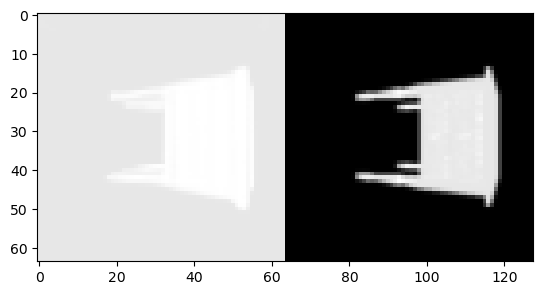

In [15]:
camera_num = 32
targ_cam = target_imgs[0][camera_num].unsqueeze(0).squeeze()
plt.imshow(torch.hstack((ren_imgs[camera_num] / torch.max(ren_imgs[camera_num]), targ_cam / torch.max(targ_cam))), cmap='gray')

In [16]:
# import imageio
# from skimage import img_as_ubyte
from PIL import Image
from torchvision.transforms.functional import to_pil_image

imgs = list()
save_path = Path('./recreated_models')
save_path.mkdir(exist_ok=True)
for camera_num, img in enumerate(ren_imgs):
    targ_cam = target_imgs[0][camera_num].unsqueeze(0).squeeze()
    imgs.append(to_pil_image(torch.hstack((ren_imgs[camera_num] / torch.max(ren_imgs[camera_num]), targ_cam)), mode='L'))
    
# imageio.mimsave('model_recreated16.gif', imgs)
imgs[0].save(save_path / "GAN_not_last_table.gif", save_all=True, append_images=imgs[1:], duration=100, loop=0)

In [ ]:
dataset